In [33]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
df = pd.read_csv(r'E:\UG - Project\diabetes\diabetes+130-us+hospitals+for+years+1999-2008\diabetic_data.csv')

In [4]:
df.select_dtypes(include=['object','category']).columns

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [5]:
df.select_dtypes(include=['float','int']).columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses'],
      dtype='object')

In [6]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [7]:
# dropping unwanted columns 
drop_cols = ['encounter_id', 'patient_nbr', 'weight', 'payer_code']

In [9]:
df.drop(columns=drop_cols,inplace = True)

In [11]:
 # 2. Missing value summary

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, missing_pct], axis=1)
missing_df.columns = ['missing_count', 'missing_pct']
print(missing_df[missing_df['missing_count']>0])

               missing_count  missing_pct
max_glu_serum          96420        94.75
A1Cresult              84748        83.28


In [12]:
df.drop(columns = ['max_glu_serum','A1Cresult'], inplace= True)

In [13]:
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, missing_pct], axis=1)
missing_df.columns = ['missing_count', 'missing_pct']

print(missing_df[missing_df['missing_count']>0])

Empty DataFrame
Columns: [missing_count, missing_pct]
Index: []


In [14]:
# 3. Drop duplicates (if any)
n_before = len(df)
df = df.drop_duplicates()
n_after = len(df)
print(f"Dropped {n_before - n_after} duplicate rows")

Dropped 0 duplicate rows


In [17]:
# 4. Target and sample encoding decisions
# Suppose 'readmitted' is the target. Convert target to binary or multiclass depending on your goal:
# common mapping: readmitted = '<30' / '>30' / 'NO'  --> you could do binary (readmitted vs not) or 3-class
print(df['readmitted'].value_counts(dropna=False))

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


In [21]:

mapping = {'NO': 0, '>30': 1, '<30': 2}
df['readmitted_num'] = df['readmitted'].map(mapping)

# Verify the mapping
print(df[['readmitted', 'readmitted_num']].head())


  readmitted  readmitted_num
0         NO               0
1        >30               1
2         NO               0
3         NO               0
4         NO               0


In [26]:
# 1️⃣ Identify feature types
numeric_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

ordinal_cols = ['age']   # age bins like [0-10), [10-20), etc.

# everything else (except target) is categorical
excluded = ['readmitted', 'readmitted_num']  # your target columns
categorical_cols = [col for col in df.columns if col not in numeric_cols + ordinal_cols + excluded]

print("Numeric columns:", numeric_cols)
print("Ordinal columns:", ordinal_cols)
print("Categorical columns:", categorical_cols[:10])  # just to check


Numeric columns: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Ordinal columns: ['age']
Categorical columns: ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin']


In [28]:
X = df.drop(columns=excluded)
y = df['readmitted_num']


Accuracy: 0.6868428810061904

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.84      0.74     10973
           1       0.59      0.35      0.44      7109
           2       1.00      1.00      1.00      2272

    accuracy                           0.69     20354
   macro avg       0.75      0.73      0.73     20354
weighted avg       0.68      0.69      0.67     20354



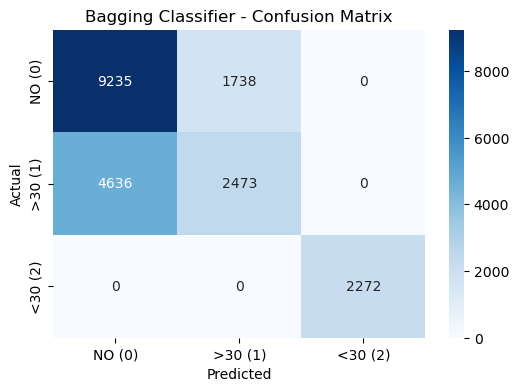

In [30]:
# Step 6: Bagging Model (Classification)

# ============================
# 🧩 BAGGING CLASSIFIER MODEL
# ============================

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# Split the data
# ----------------------------
X = df.drop(columns=['readmitted', 'readmitted_num'])
y = df['readmitted_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------
# Preprocessing + Model pipeline
# ----------------------------
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# numeric, ordinal, categorical columns (same as before)
numeric_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

ordinal_cols = ['age']
categorical_cols = [c for c in X.columns if c not in numeric_cols + ordinal_cols]

# Pipelines
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[[
        '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
        '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'
    ]]))
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine
preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_cols),
    ('ord', ordinal_pipe, ordinal_cols),
    ('cat', categorical_pipe, categorical_cols)
])

# ----------------------------
# Define Bagging model
# ----------------------------
base_model = DecisionTreeClassifier(random_state=42, max_depth=6)
bagging_model = BaggingClassifier(
    estimator=base_model,
    n_estimators=50,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42
)

# Pipeline
model = Pipeline([
    ('preprocess', preprocessor),
    ('bagging', bagging_model)
])

# ----------------------------
# Train
# ----------------------------
model.fit(X_train, y_train)

# ----------------------------
# Evaluate
# ----------------------------
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['NO (0)', '>30 (1)', '<30 (2)'],
            yticklabels=['NO (0)', '>30 (1)', '<30 (2)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Bagging Classifier - Confusion Matrix')
plt.show()



Accuracy: 0.6981920015721725

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.87      0.76     10973
           1       0.62      0.34      0.44      7109
           2       1.00      1.00      1.00      2272

    accuracy                           0.70     20354
   macro avg       0.76      0.74      0.73     20354
weighted avg       0.69      0.70      0.67     20354



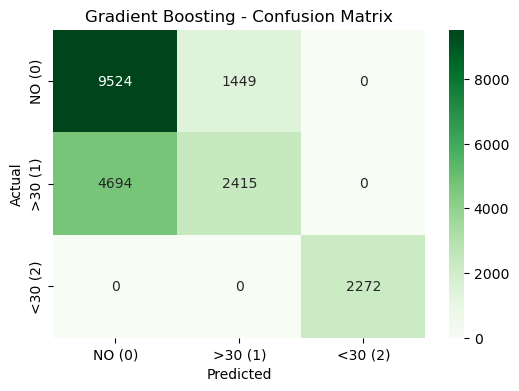

In [31]:
# ============================
# ⚡ BOOSTING CLASSIFIER MODEL
# ============================

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# Split the data (reuse if already done)
# ----------------------------
X = df.drop(columns=['readmitted', 'readmitted_num'])
y = df['readmitted_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------
# Preprocessing (same as before)
# ----------------------------
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

ordinal_cols = ['age']
categorical_cols = [c for c in X.columns if c not in numeric_cols + ordinal_cols]

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[[
        '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
        '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'
    ]]))
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_cols),
    ('ord', ordinal_pipe, ordinal_cols),
    ('cat', categorical_pipe, categorical_cols)
])

# ----------------------------
# Define Boosting model
# ----------------------------
boost_model = GradientBoostingClassifier(
    n_estimators=150,     # number of trees
    learning_rate=0.05,   # step size
    max_depth=3,          # tree depth
    random_state=42
)

# Pipeline
model = Pipeline([
    ('preprocess', preprocessor),
    ('boosting', boost_model)
])

# ----------------------------
# Train
# ----------------------------
model.fit(X_train, y_train)

# ----------------------------
# Evaluate
# ----------------------------
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=['NO (0)', '>30 (1)', '<30 (2)'],
            yticklabels=['NO (0)', '>30 (1)', '<30 (2)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boosting - Confusion Matrix')
plt.show()


# Clustering + Visualization